In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# 1. Data Preprocessing

In [ ]:
base_dir = Path('./RMHD/raw data')  # Current dir
monthly_df = []
years = ['2019', '2020', '2021', '2022']

for year in years:
    year_dir = base_dir / year
        
    print(f"Processing year: {year}")
    # month folder in year
    for subdir_path in year_dir.iterdir():
        if not subdir_path.is_dir():
            continue
            
        print(f"  Processing subdirectory: {subdir_path.name}")
        # Find all CSV files in the subdir
        csv_files = list(subdir_path.glob('*.csv'))
        
        for csv_file in csv_files:
            print(f"    Reading file: {csv_file.name}")
            df = pd.read_csv(csv_file)
            df = df.drop(df.columns[0], axis=1) # drop first col
            monthly_df.append(df)

# Concat all dataframes
if monthly_df:
    df = pd.concat(monthly_df, ignore_index=True)
else:
    print("No CSV files found or all files were empty.")

df.to_csv('RMHD.csv', index=False)

In [14]:
df = pd.read_csv('RMHD.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1851580 entries, 0 to 1851579
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   author       object
 1   created_utc  int64 
 2   score        int64 
 3   selftext     object
 4   subreddit    object
 5   title        object
 6   timestamp    object
dtypes: int64(2), object(5)
memory usage: 98.9+ MB


In [ ]:
# find nan in each column
print(df.isnull().sum())
# drop rows with nan
df.dropna(inplace=True)

author             0
created_utc        0
score              0
selftext       54564
subreddit          0
title              8
timestamp          0
dtype: int64


In [ ]:
# convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.drop(columns=['created_utc'], inplace=True)

subreddit
depression      620317
SuicideWatch    452458
mentalhealth    298409
Anxiety         268539
lonely          153575
Name: count, dtype: int64


Text(0.5, 1.0, 'Subreddit distribution')

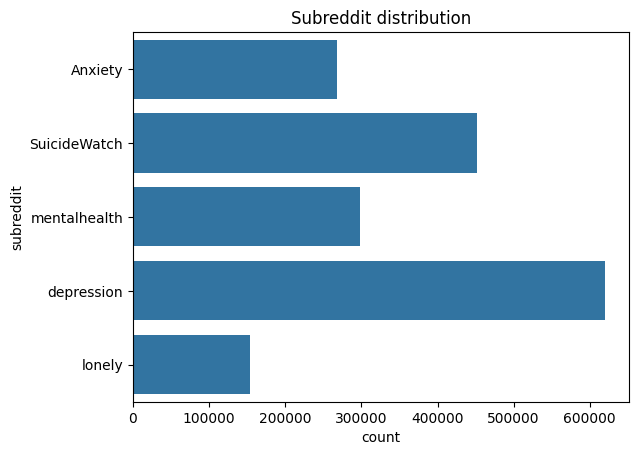

In [73]:
print(df['subreddit'].value_counts().head(10))
# keep only top 5
top5 = df['subreddit'].value_counts().head(5).index
df = df[df['subreddit'].isin(top5)]

sns.countplot(y='subreddit', data=df)
plt.title('Subreddit distribution')

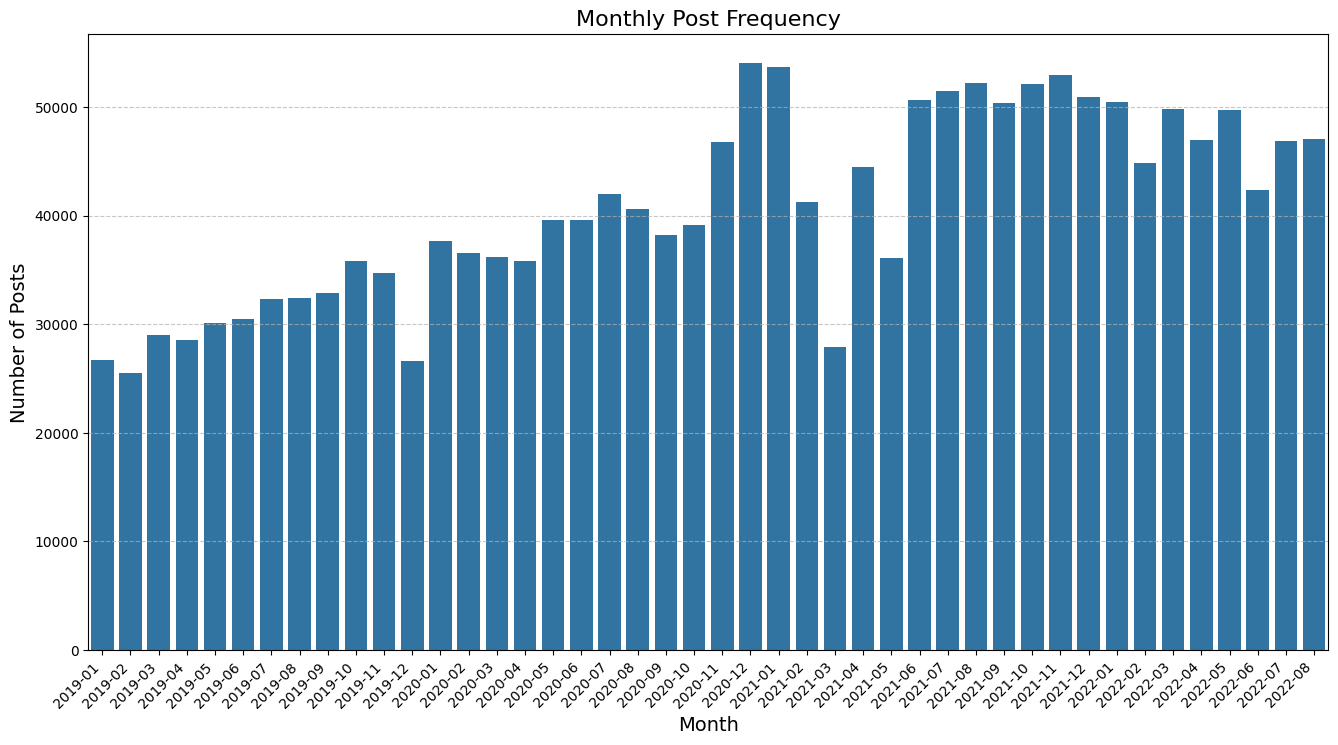

In [72]:
plt.figure(figsize=(16, 8))

sns.barplot(df['timestamp'].dt.to_period('M').value_counts().sort_index())

# Customize appearance
plt.title('Monthly Post Frequency', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Text Preprocessing 

In [42]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove Reddit formatting tags [text], (text)
    text = re.sub(r'\[.*?\]|\(.*?\)', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize text into words
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply lemmatization
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens 
                    if word not in stop_words and len(word) > 1]
    
    # Rejoin into a single string
    return ' '.join(cleaned_tokens)

# Apply preprocessing to title and body text
# With lemmatization (default)
df['title_processed'] = df['title'].apply(preprocess_text)
df['selftext_processed'] = df['selftext'].apply(preprocess_text)

# Display example results
print("Original Title:")
print(df['title'].iloc[0])
print("\nProcessed Title:")
print(df['title_processed'].iloc[0])

print("Original Selftext:")
print(df['selftext'].iloc[0])
print("\nProcessed Selftext:")
print(df['selftext_processed'].iloc[0])

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/zhouyi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhouyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zhouyi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original Title:
how to be a journalist when you have social anxiety?

Processed Title:
journalist social anxiety
Original Selftext:
I've always wanted to share peoples stories, of all walks of life and all manner of topics, and what better way to do that than become a journalist? My hard work pays off, and I get into university. I start my first year. Towards the end of the first year and start of the second, I am diagnosed with General Anxiety Disorder in combination with social anxiety. And depression. how on earth do I do my assignments, which involves talking to many people in person, and videoing them in their everyday routines and their general lives. So not only the anxiety of having to talk to someone new, ask a stranger questions but also follow said stranger/interviewee around with a camera.

I'm heartbroken. This doesn't seem feasible at the moment, and I don't know what to do.

TL;DR once hopeful journalist with anxiety

Processed Selftext:
ive always wanted share people st

In [43]:
df.to_csv('RMHD_TextProcessed.csv', index=False)

In [48]:
# visualize the text
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

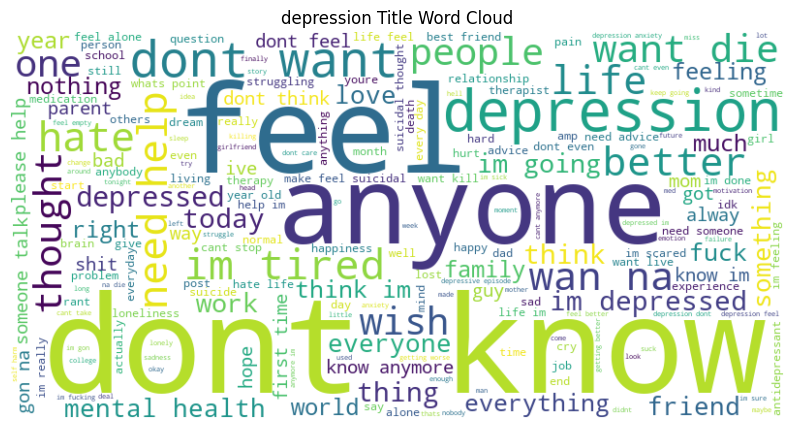

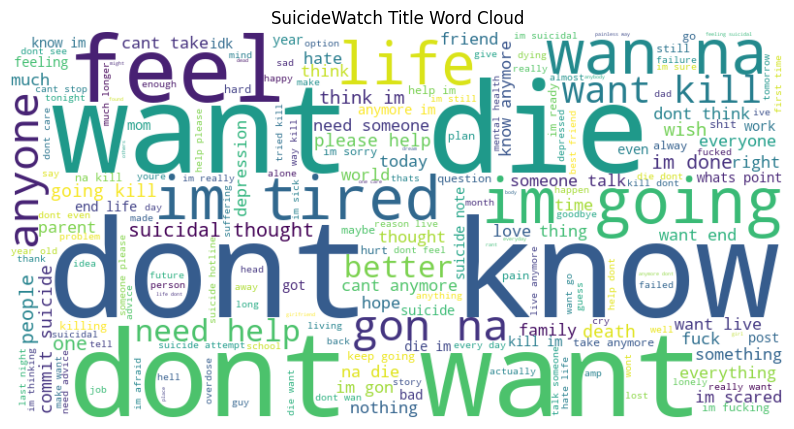

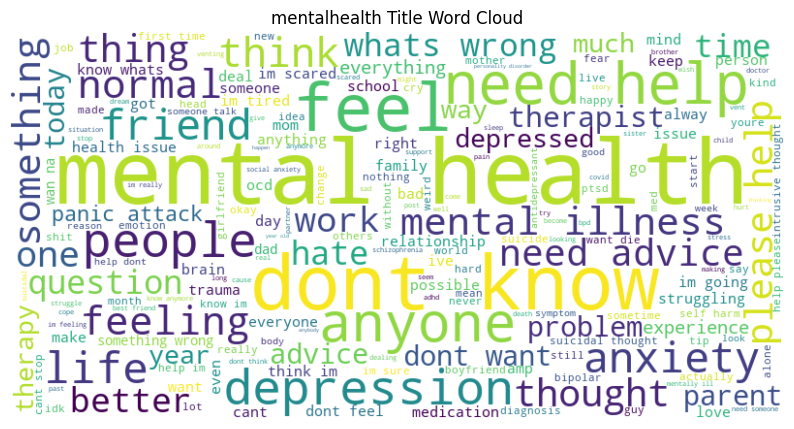

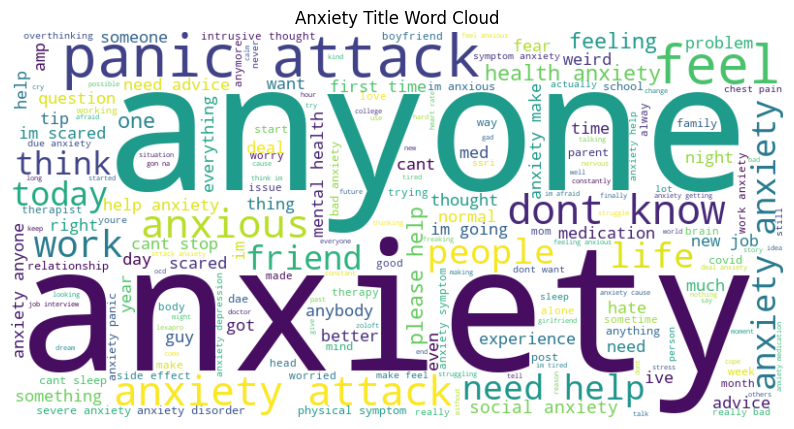

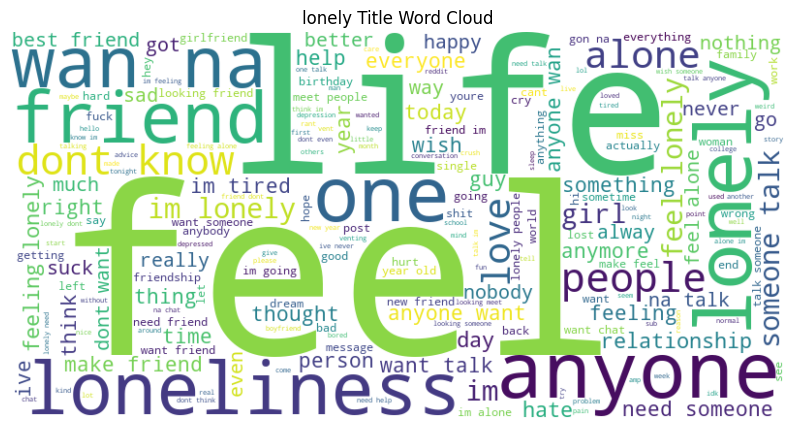

In [47]:
for subreddit in top5:
    # only title
    text = ' '.join(df[df['subreddit'] == subreddit]['title_processed'])
    plot_wordcloud(text, f"{subreddit} Title Word Cloud")

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# subsample data to speed up
sample_size = 10000
df_sample = df.groupby('subreddit').apply(lambda x: x.sample(min(len(x), sample_size//len(df['subreddit'].unique())))).reset_index(drop=True)

print(f"Subsampled data size: {df_sample.shape}, original data size: {df.shape}")

vectorizer = CountVectorizer(
    max_features=1000,  
    max_df=0.95,        # filter out words that appear in more than 95% of documents
    min_df=10,          # filter out words that appear in less than 10 documents
    stop_words='english'
)

text_for_lda = df_sample['title_processed'] + " " + df_sample['selftext_processed']

# convert text to word frequency matrix
X = vectorizer.fit_transform(text_for_lda)
print(f"Word frequency matrix shape: {X.shape}")

print("Fitting LDA model...")
lda = LatentDirichletAllocation(
    n_components=5, 
    random_state=0,
    n_jobs=-1,           
    max_iter=10,         
)

lda.fit(X)

feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-11:-1]  # get top 10 words
    top_words = [feature_names[idx] for idx in top_words_idx]
    print(f"Topic #{i+1}:")
    print(", ".join(top_words))
    print()

Subsampled data size: (10000, 8), original data size: (1793298, 8)
Word frequency matrix shape: (10000, 1000)
Fitting LDA model...
Topic #1:
im, dont, want, life, feel, know, like, ive, anymore, fucking

Topic #2:
im, like, feel, dont, know, really, want, ive, time, thing

Topic #3:
friend, year, school, time, im, life, job, really, dont, got

Topic #4:
people, like, im, feel, dont, life, thing, know, friend, make

Topic #5:
anxiety, im, ive, day, like, time, feel, help, attack, really



Topic #1: Keywords such as “dont”, “want”, “life”, “feel”, “anymore”, “fucking” suggest strong mood swings that may involve despair, helplessness, or dissatisfaction with life, and may even involve depression or suicidal thoughts.

Topic #2: Keywords such as “feel”, “really”, “want”, “time”, “thing” suggest that the topic may be related to inner feelings and confusion in life, and may involve self-doubt or uncertainty.

Topic #3: Keywords such as “friend”, “year”, “school”, “job” suggest that this topic may be related to life experiences such as changes in upbringing, education, work, and friendships.

Topic #4: Keywords such as “people”, “like”, “friend”, “make” suggest that this topic may be related to social relationships, interpersonal interactions, and perceptions of other people or society, and may be associated with feelings of loneliness or social anxiety.

Topic #5: Keywords such as “anxiety”, “attack”, “help”, “day”, “time” explicitly point to symptoms of anxiety and may relate to panic attacks, help-seeking, and mental health issues.

# Feature Engineering and Modeling (To be continue)